In [1]:
from library.database_api import DB_API
from library.lima_node_api import getWeightByHour

#### Función auxiliar para imprimir el grafo en la consola

In [2]:
def buildGraph(graph, func, limit=None):
  text = ''
  i = 1
  for key in graph.keys():
    if limit:
      if i > limit:
        break

    text += f'{key}:'

    for value in graph[key]:
      text += f'{value}' + (', ' if value != graph[key][-1] else '')

    text += '\n'
    i+=1
  
  func(text)

### Creación del grafo
Hacemos una petición a la base de datos donde obtenemos los registros. En cada registro tenemos los atributos source, target y cost. Source vendría a ser un nodo de donde parte una arista y Target otro nodo donde culmina esa arista. Cost es un valor precalculado que es igual a la distancia/velocidad. Finalmente todo se almacena en un diccionario donde las keys son los ids de los nodos (source) y sus values son arreglos de tuplas, donde cada tupla tiene el id de un nodo (target) y el costo que conlleva ir del nodo source al target

In [3]:
dbApi = DB_API()

flags = DB_API.SOURCE_ID + DB_API.TARGET_ID + DB_API.COST
sources_targets = dict()

rows = dbApi.getIntersections(flags)
for row in rows:
    if row[0] not in sources_targets:
        sources_targets[row[0]] = []
    sources_targets[row[0]].append((row[1], row[2]))

dbApi.endDbConnection()

buildGraph(sources_targets, print, 5)

source,target,cost
1:(6, 0.0005568)
6:(90275, 5.77e-05)
90275:(79, 0.0002604)
79:(51668, 0.0005382), (3466, 0.0015671)
51668:(7, 0.0001547), (3467, 0.0024725)



In [1]:
from library.database_api import DB_API

### Arreglo de nodos
Este arreglo se usa para tener una lista de todos los nodos. No se repite ningún nodo y no están clasificados en source o target, sino que todos están como un valor numérico en la lista. Servirá para que en el algoritmo de dijkstra, al diccionario que genere se le pueda asignar todas las llaves con todos los ids de todos los nodos independientemente si es nodo source o target

In [4]:
dbApi = DB_API()

query = 'SELECT table1.source FROM hh_2po_4pgr table1 union SELECT table2.target FROM hh_2po_4pgr table2'
nodeKeys = dbApi.customQuery(query)
# print(rows)

dbApi.endDbConnection()

### Algoritmo Dijkstra
El algoritmo funciona a partir de un diccionario que va a contener todos los costos y los caminos que se debe recorrer para llegar a un nodo. Es una versión basada en la enseñada por el profesor Canaval, pero adaptada para que funcione con diccionario y que aplique el algoritmo de obtención de pesos según una hora.

In [6]:
import heapq as hq
import math

def dijkstra(G, keys, s, hour=1):
  node_data = dict()
  for key in keys:
    node_data[key[0]] = {'cost': math.inf, 'path': None}

  n = len(G)
  visited = []
  pqueue = [(0, s)]

  while pqueue:
    g, u = hq.heappop(pqueue)
    if u not in visited:
      visited.append(u)
      if u in G.keys():
        for ngbs in G[u]:
          v, w = ngbs
          w = getWeightByHour(w, hour)
          if v not in visited:
            f = g + w
            if f < node_data[v]['cost']:
              node_data[v]['cost'] = f
              node_data[v]['path'] = u
              hq.heappush(pqueue, (f, v))

  return node_data

In [7]:
node_costs = dijkstra(sources_targets, nodeKeys, 1)

In [8]:
node_costs

{1: {'cost': inf, 'path': None},
 2: {'cost': 0.0040316, 'path': 3472},
 3: {'cost': 0.0076121, 'path': 3165},
 4: {'cost': 0.008109, 'path': 3},
 5: {'cost': 0.011419400000000001, 'path': 69},
 6: {'cost': 0.0005568, 'path': 1},
 7: {'cost': 0.0015678, 'path': 51668},
 8: {'cost': 0.022535899999999998, 'path': 20265},
 9: {'cost': 0.0273723, 'path': 20253},
 10: {'cost': 0.002601, 'path': 7},
 11: {'cost': 0.009393700000000001, 'path': 64984},
 12: {'cost': 0.013652100000000002, 'path': 16},
 13: {'cost': 0.044330199999999986, 'path': 20},
 14: {'cost': 0.010034900000000001, 'path': 15},
 15: {'cost': 0.009831500000000002, 'path': 64985},
 16: {'cost': 0.009590500000000002, 'path': 11},
 17: {'cost': 0.027567699999999997, 'path': 9},
 18: {'cost': 0.015184900000000001, 'path': 22},
 19: {'cost': 0.04136779999999999, 'path': 3850},
 20: {'cost': 0.042760499999999986, 'path': 19},
 21: {'cost': 0.016585000000000003, 'path': 18},
 22: {'cost': 0.014121800000000002, 'path': 12},
 23: {'co

In [8]:
import numpy as np

In [9]:
dbApi = DB_API()

query = 'SELECT table1.x1, table1.y1 FROM hh_2po_4pgr table1 union SELECT table2.x2, table2.y2 FROM hh_2po_4pgr table2'
rows = dbApi.customQuery(query)
# print(rows)
n = len(rows)
nodes_coords = np.zeros((n, 2))

for i, row in enumerate(rows):
    nodes_coords[i][0] = row[1]
    nodes_coords[i][1] = row[0]

print(nodes_coords[:10])

dbApi.endDbConnection()

[[-12.0663367 -77.236831 ]
 [-12.0766862 -77.2345542]
 [-12.0664796 -77.2343618]
 [-12.0725945 -77.2213792]
 [-12.0729722 -77.2201347]
 [-12.0767072 -77.2189974]
 [-12.0784278 -77.2172593]
 [-12.078071  -77.2167229]
 [-12.0799595 -77.2162937]
 [-12.0795818 -77.2162079]]


In [10]:
import matplotlib.pyplot as plt

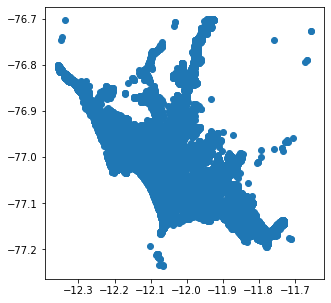

In [13]:
plt.subplots(figsize=(5, 5))
plt.scatter(nodes_coords[:, 0], nodes_coords[:, 1])